In [23]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from brokenaxes import brokenaxes
sns.set_style('white')
sns.set_context('notebook')
sns.set_palette('dark')

### Read in data 

In [27]:
X = np.genfromtxt('../data/combined_binned.dat',skip_header=1).T

In [30]:
t,y,s,o=X
ou = np.unique(o)
x_ranges = []
for oo in ou:
    l = o == oo
    x_ranges.append((t[l].min()-0.1,t[l].max()+0.1))
print(x_ranges)
labels = ['XMM1','XMM2','Chandra1','XMM3']

[(476.17578999999995, 476.89547000000005), (499.12255, 500.86769000000004), (528.6104399999999, 529.64377), (634.81236, 636.53899)]


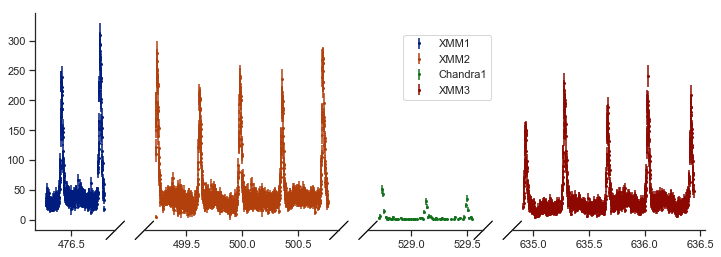

In [38]:
plt.figure(figsize=(12,4))
bax = brokenaxes(xlims=x_ranges)
for i,oo in enumerate(ou):
    l = o == oo
    bax.errorbar(t[l],y[l],yerr=s[l],fmt='.',ms=4,label=labels[i])
bax.legend(loc=(0.55,0.6))

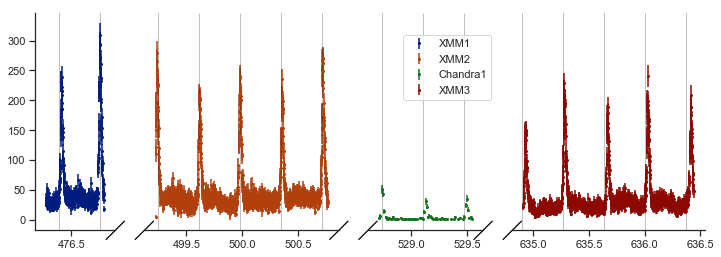

In [69]:
per_init = 0.36863 # from phase-folding
t0_init = t[np.argmax(y)]
while t0_init > t.min():
    t0_init -= per_init
plt.figure(figsize=(12,4))
bax = brokenaxes(xlims=x_ranges)
for i,oo in enumerate(ou):
    l = o == oo
    bax.errorbar(t[l],y[l],yerr=s[l],fmt='.',ms=4,label=labels[i])
t0 = t0_init
while(t0<t.max()):
    t0 += per_init
    bax.axvline(t0,c='k',lw=0.5,alpha=0.5)
bax.legend(loc=(0.55,0.6))

### Functions to fit Gaussian pulses with white noise only

#### <font color=red>TBD: test assumption of Gaussian pulses</font>

In [70]:
from scipy.optimize import minimize
import emcee, corner

In [71]:
def gauss(p, t):
    amp, mu, sig, dc = p
    return dc + amp * np.exp(-(t-mu)**2/2/sig**2)

def chi2_gauss(p, t, y, e):
    m = gauss(p, t)
    r = y - m
    return ((r/e)**2).sum()

In [72]:
def lnprob_gauss(p, t, y, e):
    return - 0.5 * chi2_gauss(p, t, y, e)

def mcmc_gauss(t, y, e, p_in, nburn = 500, nrun = 500):
    ndim = len(p_in)
    nwalkers = max(4 * ndim, 24)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_gauss, args=(t,y,e))
    # Initialize the walkers.
    p0 = p_in + 1e-4 * np.random.randn(nwalkers, ndim)
    p0, _, _ = sampler.run_mcmc(p0, nburn)
    sampler.reset()
    sampler.run_mcmc(p0, nrun)
    return sampler

In [73]:
def fit_gauss(t, y, e, p_in):
    plt.figure()
    plt.errorbar(t,y,fmt='k.',yerr=e,capsize=0,lw=0.5,ms=4,alpha=0.5)
    # first do MLE
    soln = minimize(chi2_gauss,p_in, args = (t,y,e))
    p_mle = soln.x
    treg = np.linspace(min(t), max(t), 200)
    mreg = gauss(p_mle[:4],treg)
    plt.plot(treg,mreg,'b-')
    # do MCMC
    sampler = mcmc_gauss(t, y, e, p_mle)
    # plot samples
    for i in range(50):
        # Choose a random walker and step.
        w = np.random.randint(sampler.chain.shape[0])
        n = np.random.randint(sampler.chain.shape[1])
        p = sampler.chain[w, n]
        # Plot a single sample.
        mreg = gauss(p,treg)
        plt.plot(treg, mreg, "g-", alpha=0.1,lw = 0.5)
    # MAP parameters & residuals
    samples = sampler.flatchain
    logL = sampler.flatlnprobability
    p_map = samples[np.argmax(logL),:].flatten()
    mreg = gauss(p_map,treg)
    plt.plot(treg, mreg, "r-",lw = 0.5)
    m = gauss(p_map,t)
    r = y - m
    plt.figure()
    plt.errorbar(t, r, fmt = 'k.',yerr=e,capsize=0,lw=0.5,ms=4,alpha=0.5)
    # posterior distributions
    ndim = len(p_map)
    p_med = np.zeros(ndim)
    p_err_down = np.zeros(ndim)
    p_err_up = np.zeros(ndim)
    for i in range(ndim):
        p = samples[:,i].flatten()
        l,m,u = np.percentile(p, [16, 50, 84])
        p_med[i] = m
        p_err_down[i] = m-l
        p_err_up[i] = u-m
    labels = np.array([r"$A$", r"$\mu$", r"$\sigma$",r"$C$"])
    names = np.array(['amp','loc','half-width','DC'])
    corner.corner(sampler.flatchain, quantiles=[0.16, 0.5, 0.84],truths=p_map,labels=labels)
    return names, (p_mle, p_map),(p_med,p_err_down,p_err_up), r

In [86]:
def fit_gauss_all(t, y, e, p_in = per_init, t0_in = t0_init):
    orbit = np.around((t-t0_in)/p_in).astype(int)
    ou = np.unique(orbit)
    print(ou)
    for oo in ou:
        l = orbit == oo
        plt.plot(t[l],y[l],'.')
    orb = []
    par_mle = []
    par_map = []
    par_med = []
    par_err_down = []
    par_err_up = []
    times = []
    residuals = []
    errors = []
    for oo in ou:
        print('orbit:', oo)
        l = orbit == oo
        print('no. data points:', l.sum())
        print(l.sum())
        tt = t[l]
        yy = y[l]
        ee = e[l]
        i = np.argmax(yy)
        mu_c = tt[i]
        amp_c = yy[i]
        ll = yy > amp_c/2.
        sig_c = 0.5*(tt[ll].max()-tt[ll].min())
        dc_c = np.median(yy[~ll]) 
        par_in = np.array([amp_c, mu_c, sig_c, dc_c])
        print('Initial guess par:', par_in)
        res = fit_gauss(tt, yy, ee, par_in)
        names = res[0]
        p_mle, p_map = res[1]
        p_med, p_err_down, p_err_up = res[2]
        resid = res[3]
        par_mle.append(p_mle)
        par_map.append(p_map)
        par_med.append(p_med)
        par_err_down.append(p_err_down)
        par_err_up.append(p_err_up)
        times.append(t[l])
        residuals.append(resid)
        errors.append(e[l])
        orb.append(oo)
        print('Orbit: {:d}'.format(oo))
        print('{:20s} {:10s} {:10s} {:10s} + {:10s} - {:10s}' \
              .format('Parameter','ML', 'MAP', 'Med', 'sig_up', 'sig_down'))
        for i in range(len(p_mle)):
            print('{:20s} {:15.6f} {:15.6f} {:15.6f} + {:15.6f} - {:15.6f}' \
                  .format(names[i], p_mle[i], p_map[i], p_med[i], p_err_up[i], p_err_down[i]))
    return orb, par_mle, par_map, par_med, par_err_down, par_err_up, times, residuals, errors

### Do fit without GP first

[  1   2  63  64  65  66  67 143 144 145 431 432 433 434 435]
orbit: 1
no. data points: 258
258
Initial guess par: [2.3966000e+02 4.7641352e+02 9.8400000e-03 3.4260000e+01]
Orbit: 1
Parameter            ML         MAP        Med        + sig_up     - sig_down  
amp                       179.724920      180.015661      179.783555 +        5.260716 -        5.638023
loc                       476.415752      476.415759      476.415747 +        0.000291 -        0.000267
half-width                  0.009672        0.009656        0.009691 +        0.000253 -        0.000293
DC                         31.922972       31.943091       31.919994 +        0.474250 -        0.464643
orbit: 2
no. data points: 192
192
Initial guess par: [3.0926000e+02 4.7675843e+02 1.0995000e-02 3.5120000e+01]
Orbit: 2
Parameter            ML         MAP        Med        + sig_up     - sig_down  
amp                       238.558145      238.400753      238.325419 +        5.579563 -        5.203548
loc          

/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Orbit: 67
Parameter            ML         MAP        Med        + sig_up     - sig_down  
amp                       205.746988      206.079633      205.965009 +        4.666053 -        4.789251
loc                       500.726289      500.726270      500.726294 +        0.000250 -        0.000233
half-width                  0.010407        0.010376        0.010390 +        0.000231 -        0.000228
DC                         34.455283       34.524290       34.478017 +        0.583242 -        0.578058
orbit: 143
no. data points: 18
18
Initial guess par: [5.1000000e+01 5.2873359e+02 5.7850000e-03 2.0000000e+00]
Orbit: 143
Parameter            ML         MAP        Med        + sig_up     - sig_down  
amp                        54.824205       54.105999       54.466410 +        7.694382 -        6.999177
loc                       528.740218      528.740168      528.740160 +        0.001011 -        0.001098
half-width                  0.009135        0.009156        0.009024 +        

/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Orbit: 431
Parameter            ML         MAP        Med        + sig_up     - sig_down  
amp                       114.115626      114.230566      113.283266 +        4.416090 -        4.103907
loc                       634.934690      634.934679      634.934732 +        0.000309 -        0.000330
half-width                  0.011140        0.011153        0.011194 +        0.000424 -        0.000425
DC                         15.502552       15.522295       15.486748 +        0.458682 -        0.465878
orbit: 432
no. data points: 318
318
Initial guess par: [2.2853000e+02 6.3528042e+02 9.8350000e-03 2.3920000e+01]


/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Orbit: 432
Parameter            ML         MAP        Med        + sig_up     - sig_down  
amp                       167.784140      168.001632      167.508543 +        5.042570 -        4.752603
loc                       635.283428      635.283432      635.283455 +        0.000249 -        0.000262
half-width                  0.011366        0.011345        0.011383 +        0.000273 -        0.000294
DC                         21.173262       21.201231       21.177319 +        0.331589 -        0.329466
orbit: 433
no. data points: 319
319
Initial guess par: [1.8936000e+02 6.3566931e+02 1.0415000e-02 2.4210000e+01]


/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Orbit: 433
Parameter            ML         MAP        Med        + sig_up     - sig_down  
amp                       138.016449      138.061580      138.150869 +        4.154521 -        4.289029
loc                       635.670091      635.670064      635.670078 +        0.000281 -        0.000274
half-width                  0.009932        0.009925        0.009924 +        0.000257 -        0.000255
DC                         22.369877       22.416198       22.414674 +        0.324699 -        0.356923
orbit: 434
no. data points: 318
318
Initial guess par: [2.4025000e+02 6.3603158e+02 1.0420000e-02 2.9620000e+01]


/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Orbit: 434
Parameter            ML         MAP        Med        + sig_up     - sig_down  
amp                       161.762327      161.095743      161.668208 +        4.527852 -        4.487117
loc                       636.031172      636.031189      636.031143 +        0.000271 -        0.000248
half-width                  0.010624        0.010622        0.010636 +        0.000244 -        0.000256
DC                         26.285121       26.303435       26.271312 +        0.384558 -        0.373276
orbit: 435
no. data points: 215
215
Initial guess par: [2.0875000e+02 6.3641584e+02 1.2735000e-02 2.5555000e+01]


/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Orbit: 435
Parameter            ML         MAP        Med        + sig_up     - sig_down  
amp                       146.265366      145.779013      146.215315 +        4.700704 -        4.488841
loc                       636.417279      636.417279      636.417315 +        0.000317 -        0.000315
half-width                 -0.011308       -0.011380       -0.011296 +        0.000362 -        0.000384
DC                         22.348720       22.322930       22.304413 +        0.441626 -        0.390198


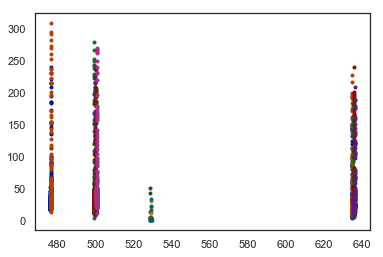

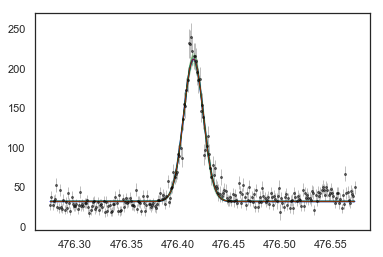

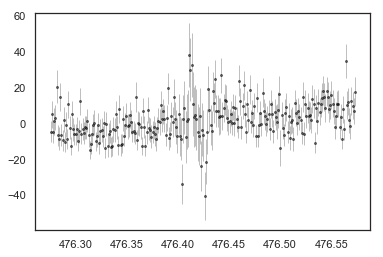

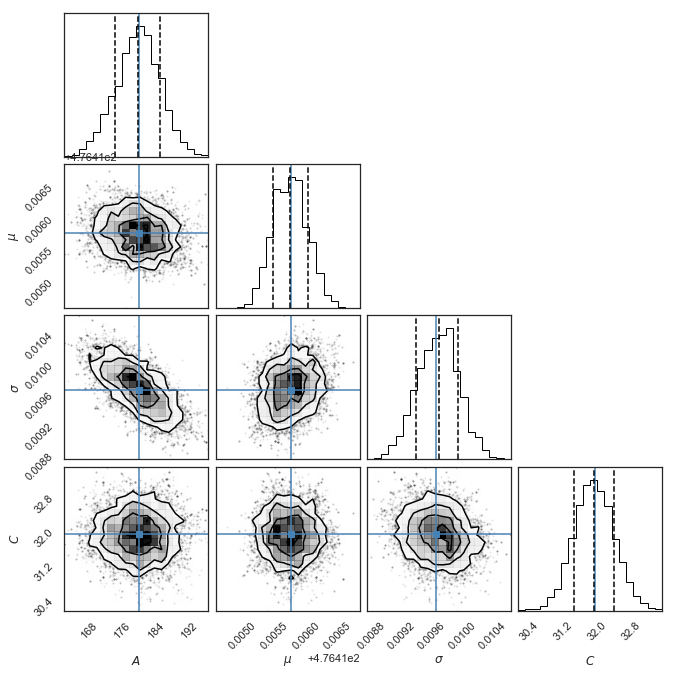

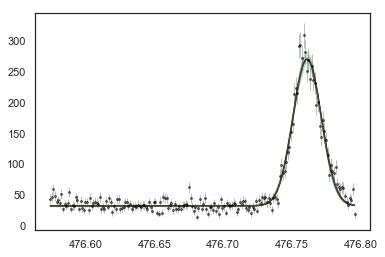

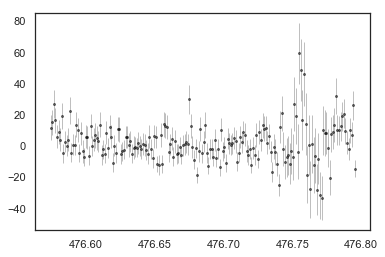

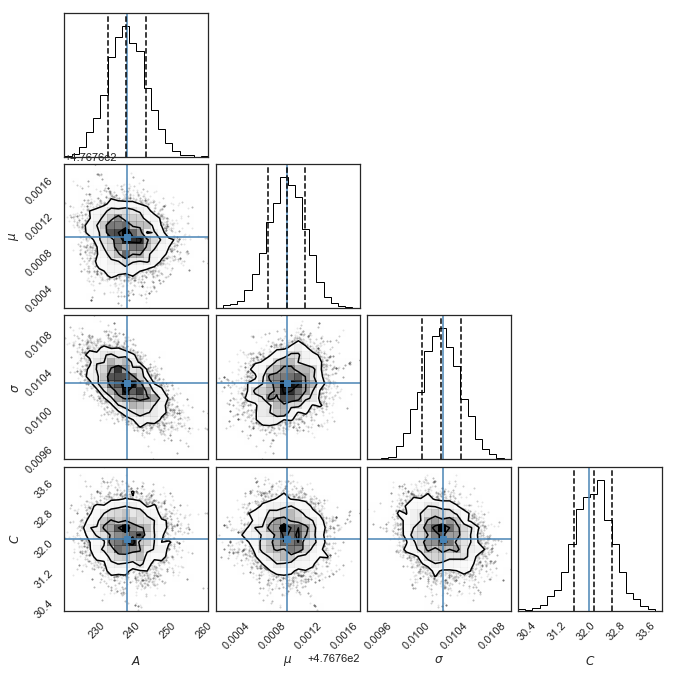

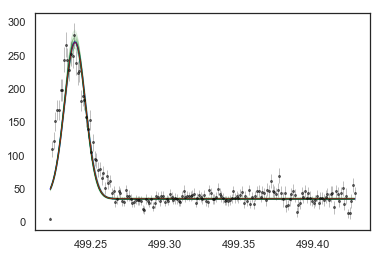

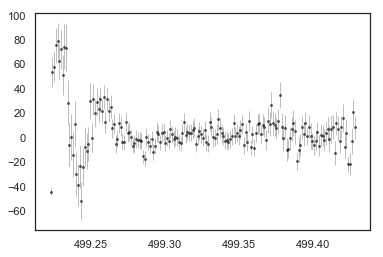

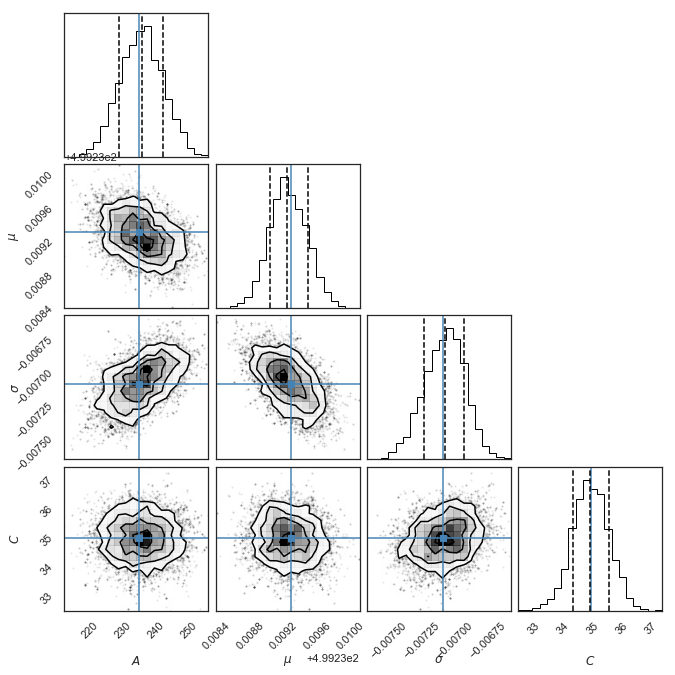

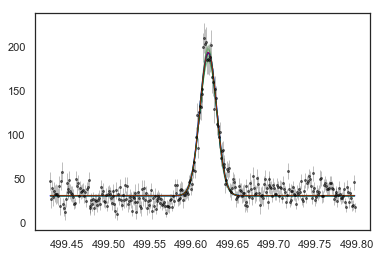

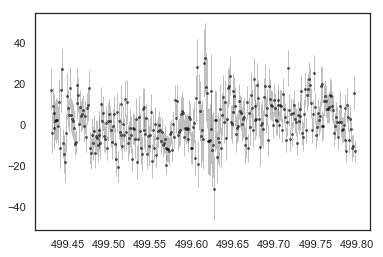

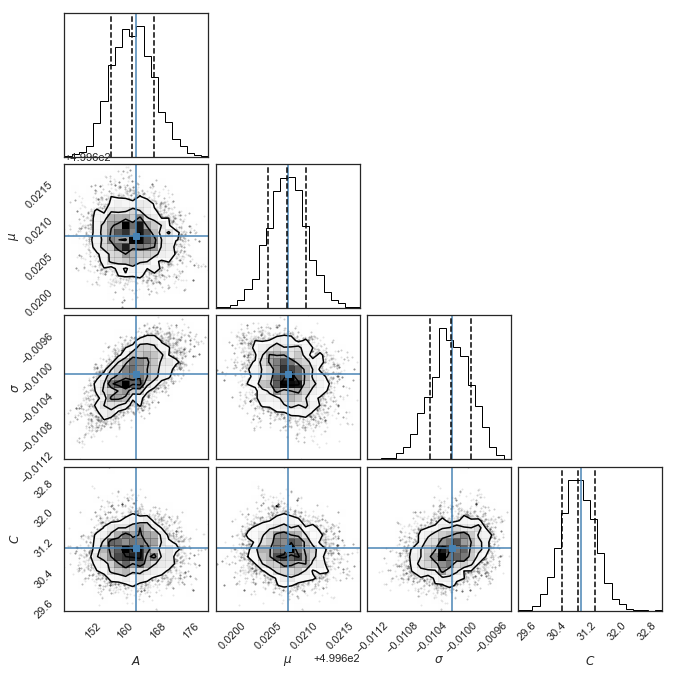

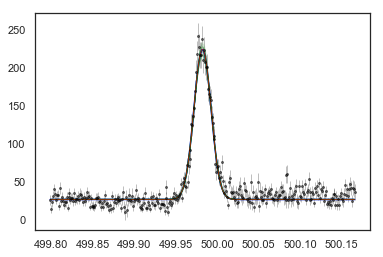

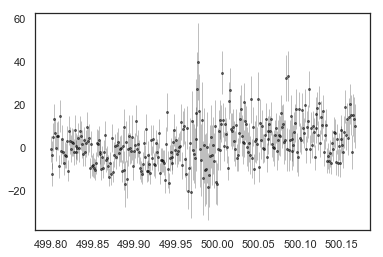

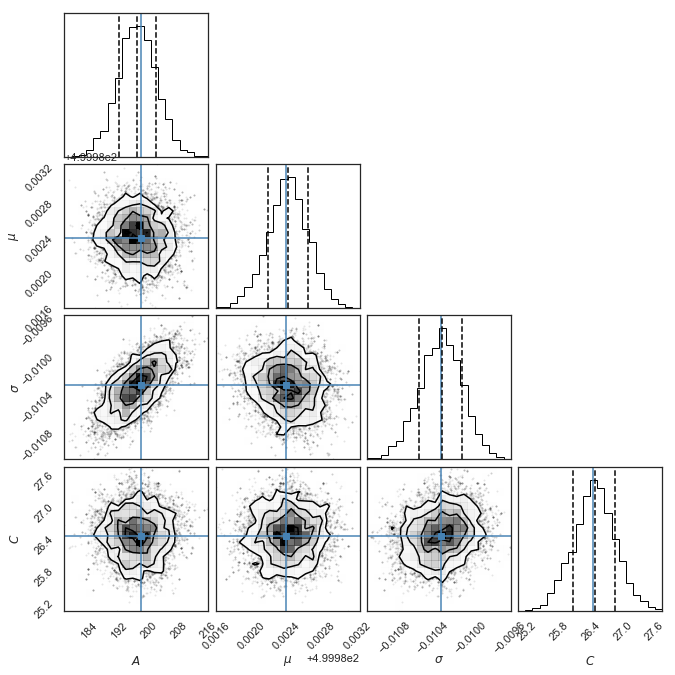

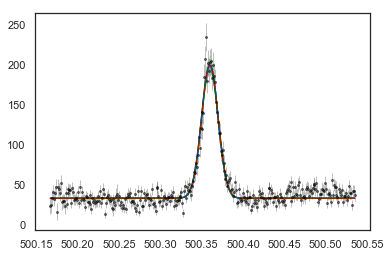

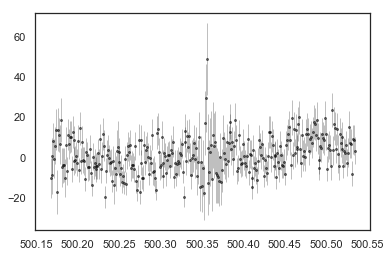

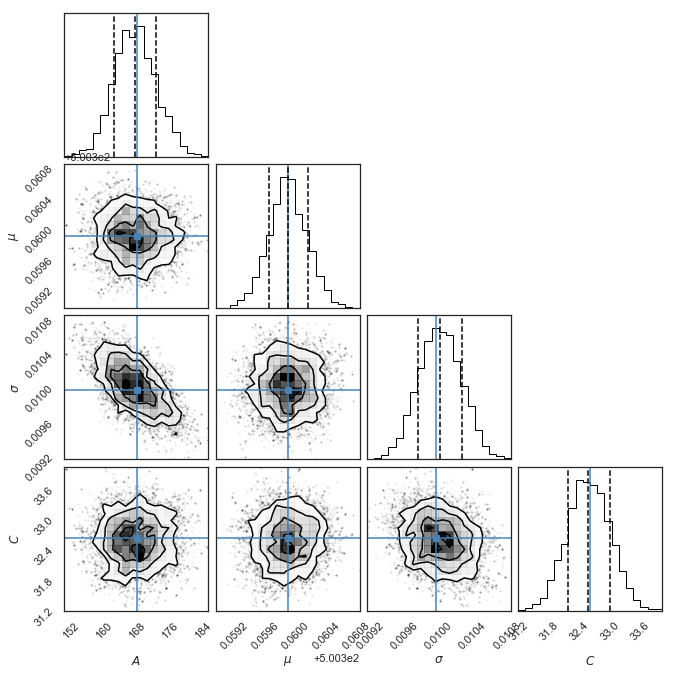

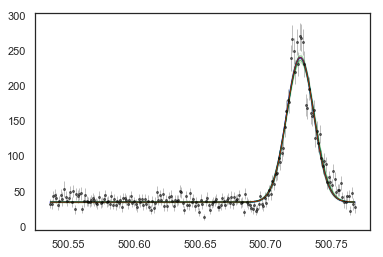

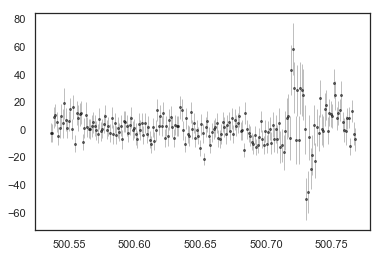

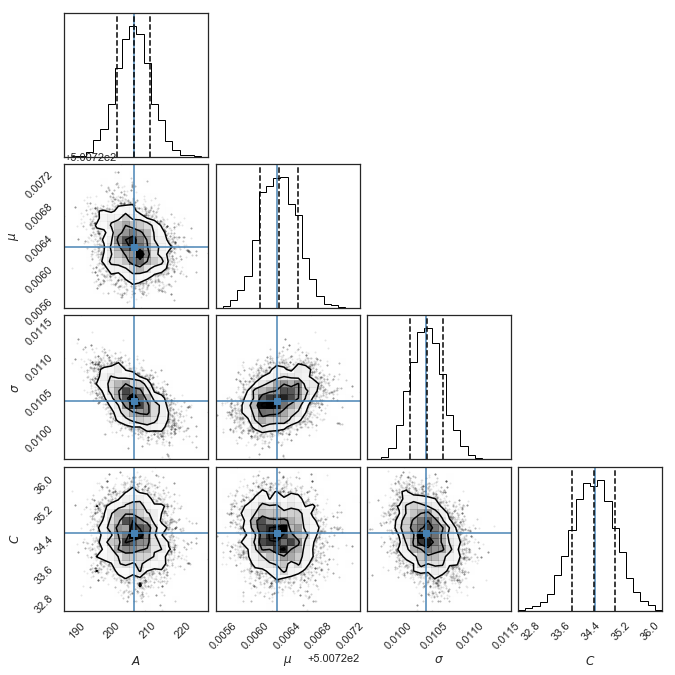

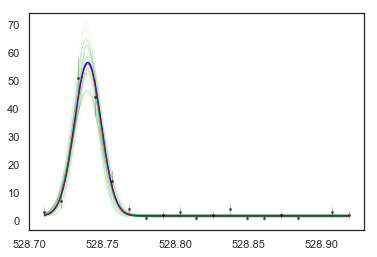

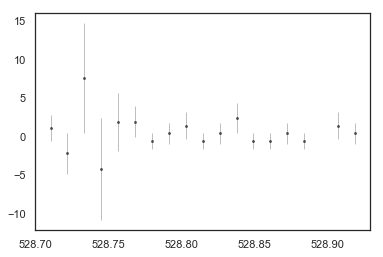

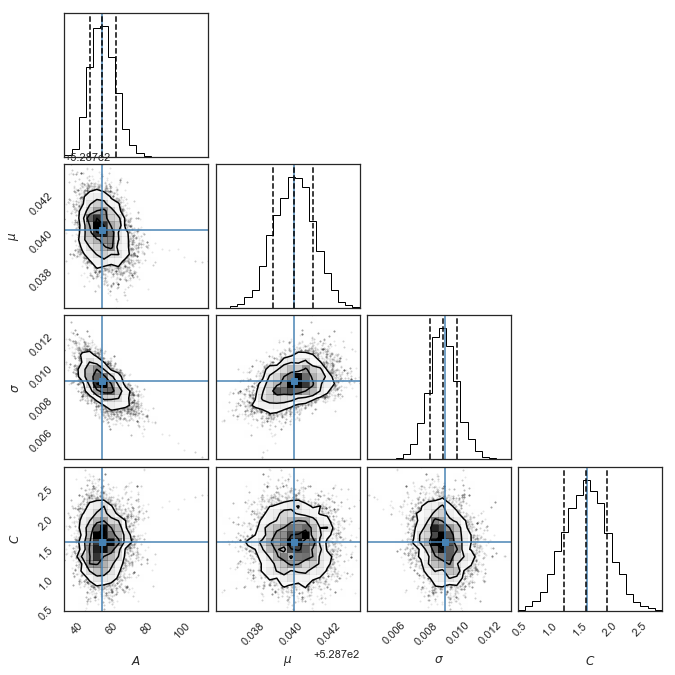

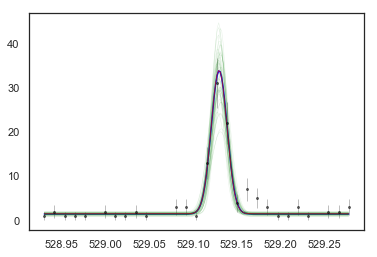

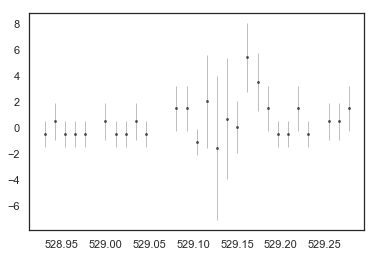

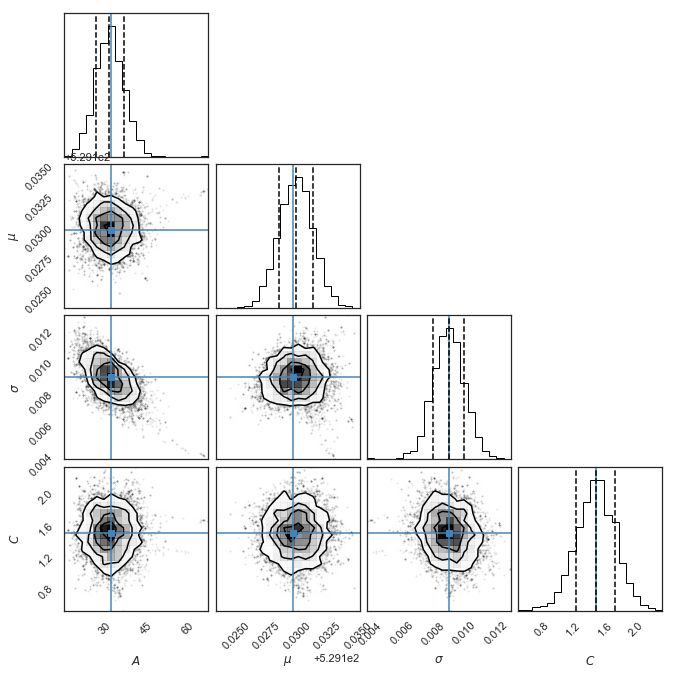

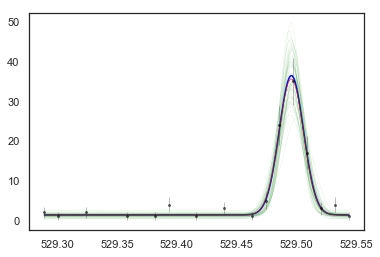

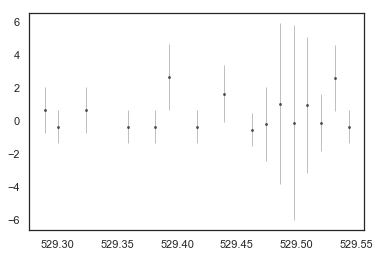

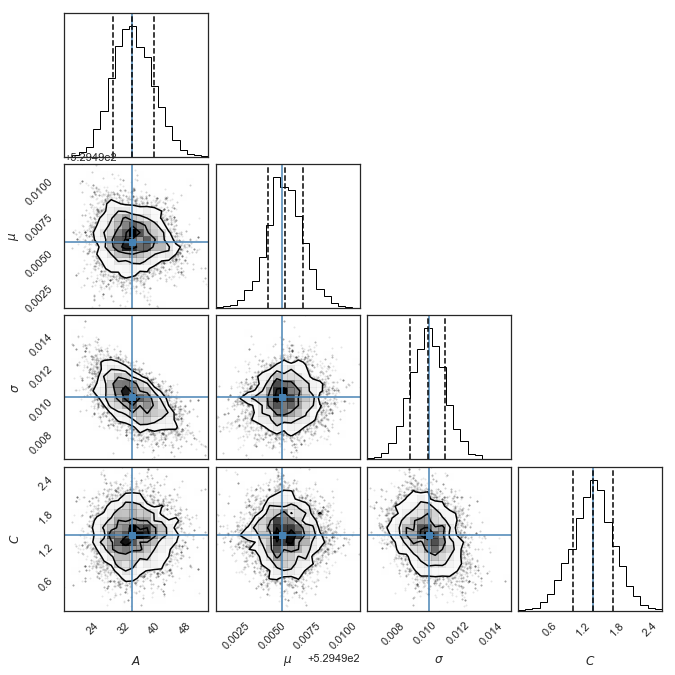

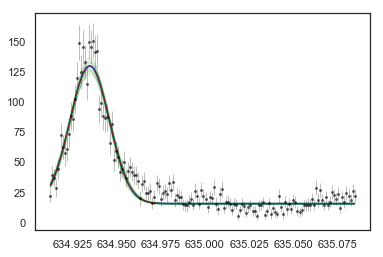

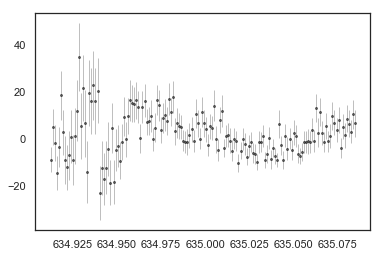

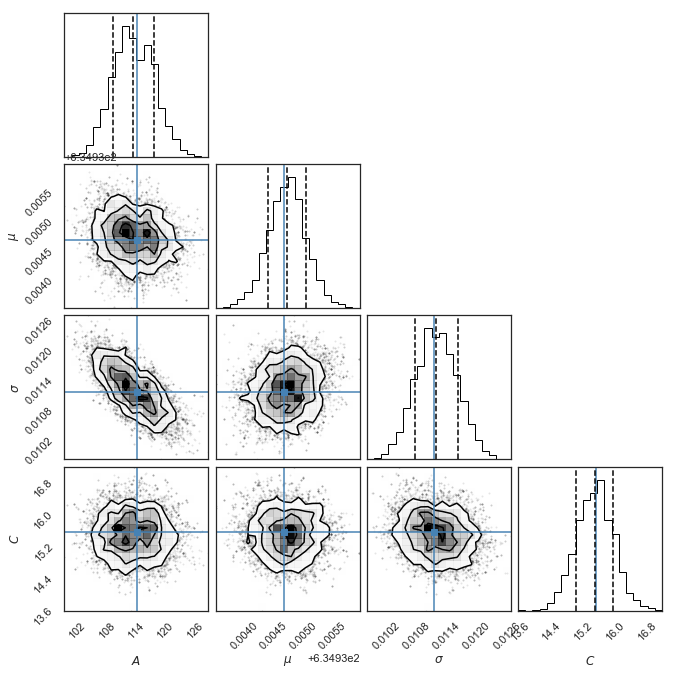

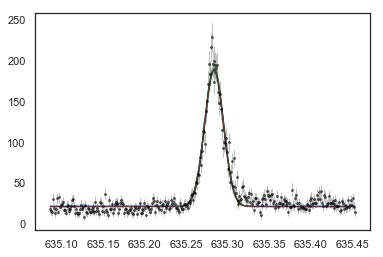

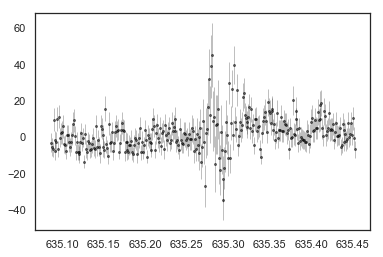

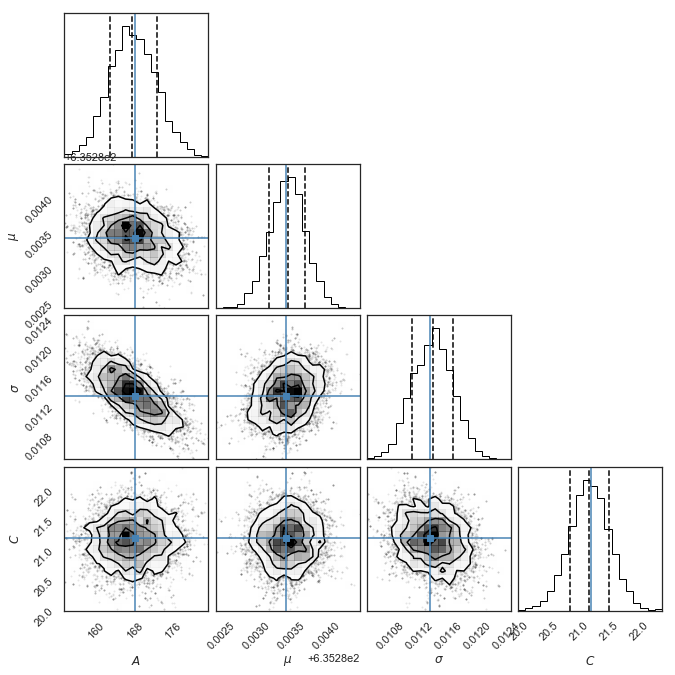

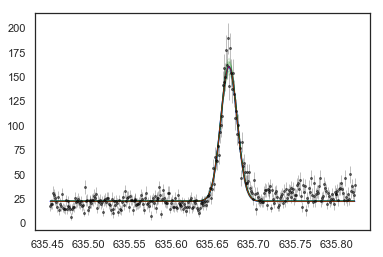

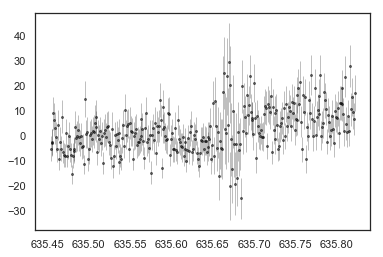

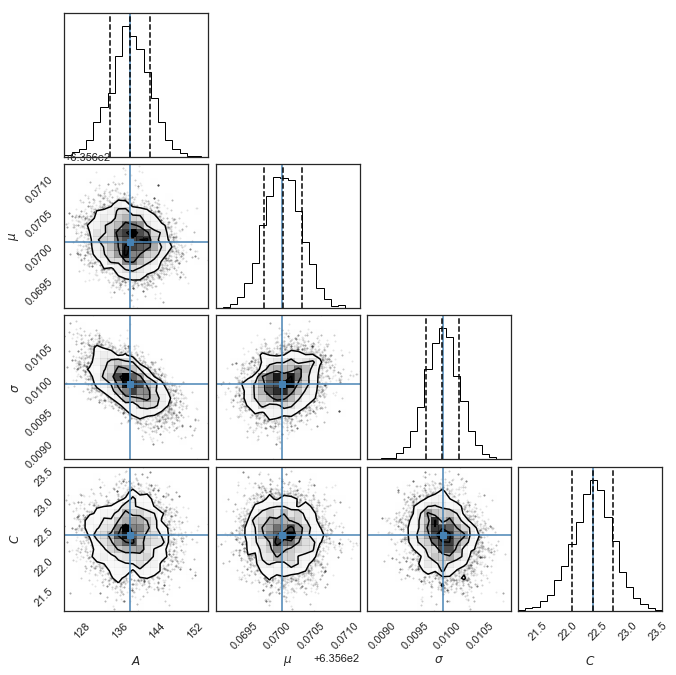

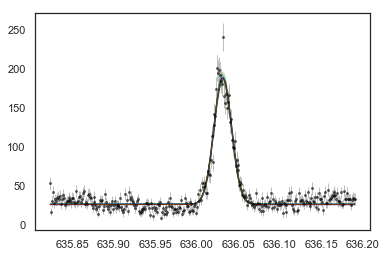

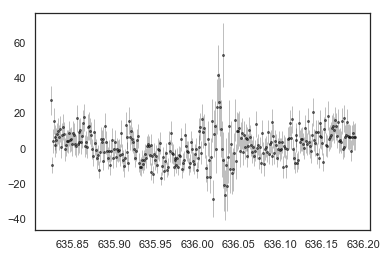

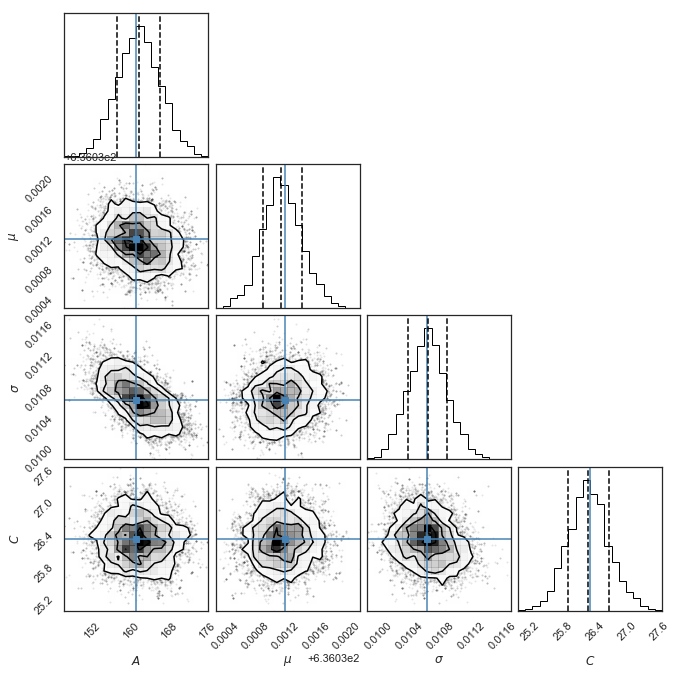

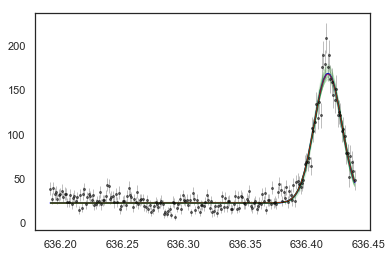

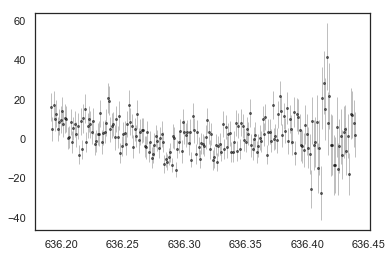

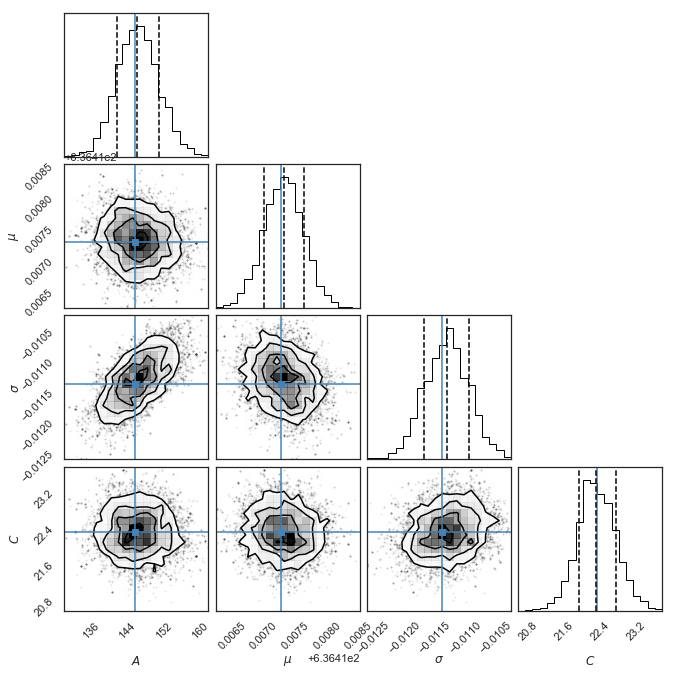

In [89]:
res = fit_gauss_all(t,y,s)

### Any evidence of period drift so far?

In [104]:
orb, _, _, par_med, par_err_up, par_err_down, _, _, _ = res
orbit_no = np.array(orb)/2.
pulse_time = np.zeros_like(orbit_no,float)
pulse_time_err = np.zeros_like(pulse_time)
pulse_width = np.zeros_like(orbit_no,float)
pulse_width_err = np.zeros_like(pulse_time)
pulse_amp = np.zeros_like(orbit_no,float)
pulse_amp_err = np.zeros_like(pulse_time)
for i in range(len(orbit_no)):
    pulse_amp[i] = par_med[i][0]
    pulse_amp_err[i] = 0.5 * (par_err_up[i][0] + par_err_down[i][0])
    pulse_time[i] = par_med[i][1]
    pulse_time_err[i] = 0.5 * (par_err_up[i][1] + par_err_down[i][1])
    pulse_width[i] = abs(par_med[i][2])
    pulse_width_err[i] = 0.5 * (par_err_up[i][2] + par_err_down[i][2])
    print(orbit_no[i],pulse_time[i],pulse_width[i],pulse_amp[i])

0.5 476.4157470076525 0.009691090415666537 179.78355475309993
1.0 476.76095633706086 0.010261161489626759 238.32541897773945
31.5 499.239247618544 0.007072620216085988 235.59843147830804
32.0 499.62076157015093 0.010148732567836796 161.66704319251207
32.5 499.9824171783413 0.010307877513657955 196.86528953155016
33.0 500.35989727489005 0.010016024056661854 167.42036395127826
33.5 500.72629379539967 0.010390490656449355 205.96500890812268
71.5 528.7401603467534 0.009024402029131273 54.46640993842516
72.0 529.1299293957397 0.008979604920140086 31.651849295278573
72.5 529.4958974752956 0.010150502707483107 34.27312994523243
215.5 634.9347316023441 0.011194318974547136 113.28326573188869
216.0 635.2834546529263 0.011382937511265729 167.5085433746708
216.5 635.6700781144879 0.009923884867876133 138.1508693107823
217.0 636.031143041098 0.010635765125765827 161.66820828097235
217.5 636.4173149273845 0.011295667602390723 146.215314761601


Best linear ephemeris (not accouting for timing uncertainties): [  0.73736837 476.02711964]


Text(0.5, 0, 'orbit number')

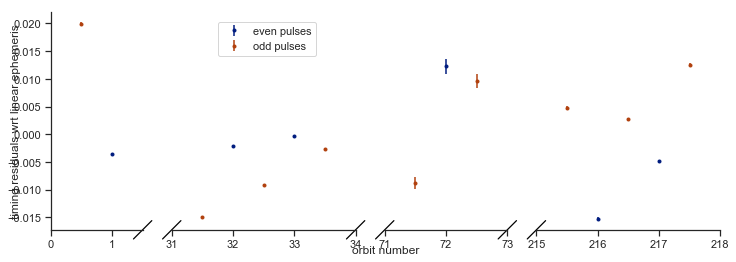

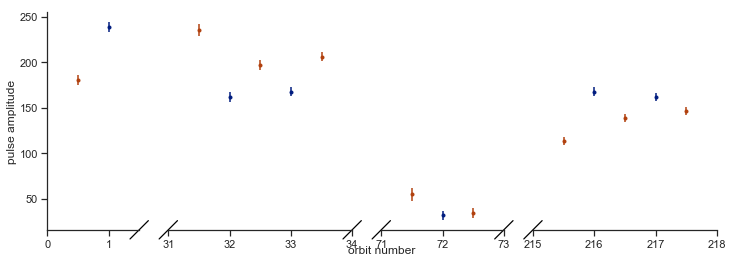

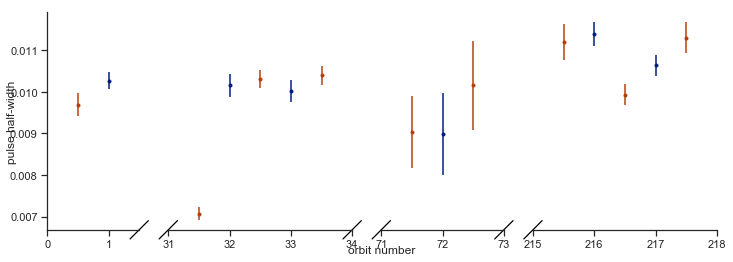

In [106]:
l1 = (orbit_no%1)==0
l2 = (orbit_no%1)==0.5
p = np.polyfit(orbit_no,pulse_time,1)
v = np.polyval(p,orbit_no)
time_res = pulse_time - v
print('Best linear ephemeris (not accouting for timing uncertainties):', p)
x_ranges_2 = ((0,1.5),(31,34),(71,73),(215,218))
plt.figure(figsize=(12,4))
bax = brokenaxes(xlims=x_ranges_2)
bax.errorbar(orbit_no[l1],time_res[l1],yerr=pulse_time_err[l1],fmt='.',label='even pulses')
bax.errorbar(orbit_no[l2],time_res[l2],yerr=pulse_time_err[l2],fmt='.',label='odd pulses')
bax.legend(loc=(0.25,0.8))
bax.set_ylabel('timing residuals wrt linear ephemeris')
bax.set_xlabel('orbit number')
plt.figure(figsize=(12,4))
bax = brokenaxes(xlims=x_ranges_2)
bax.errorbar(orbit_no[l1],pulse_amp[l1],yerr=pulse_amp_err[l1],fmt='.')
bax.errorbar(orbit_no[l2],pulse_amp[l2],yerr=pulse_amp_err[l2],fmt='.')
bax.set_ylabel('pulse amplitude')
bax.set_xlabel('orbit number')
plt.figure(figsize=(12,4))
bax = brokenaxes(xlims=x_ranges_2)
bax.errorbar(orbit_no[l1],pulse_width[l1],yerr=pulse_width_err[l1],fmt='.')
bax.errorbar(orbit_no[l2],pulse_width[l2],yerr=pulse_width_err[l2],fmt='.')
bax.set_ylabel('pulse half-width')
bax.set_xlabel('orbit number')


### Now fit residuals with GP

In [10]:
def nll_gp(p, t, y, e, gp):
    gp.set_parameter_vector(p)
    if abs(p[0]-5)>5:
        return 1e25
    if abs(p[-1]-12.5)>2.5:
        return 1e25
    try:
        gp.compute(t, yerr = e)
    except: 
        return 1e25
    return -gp.log_likelihood(y)

In [11]:
def lnprob_gp(p, t, y, e, gp):
    return - nll_gp(p, t, y, e, gp)

def mcmc_gp(t, y, e, gp, nburn = 1000, nrun = 500):
    p_in = gp.get_parameter_vector()
    ndim = len(p_in)
    nwalkers = max(4 * ndim, 24)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_gp, args=(t,y,e,gp))
    # Initialize the walkers.
    p0 = p_in + 1e-4 * np.random.randn(nwalkers, ndim)
    p0, _, _ = sampler.run_mcmc(p0, nburn)
    sampler.reset()
    sampler.run_mcmc(p0, nrun)
    return sampler

In [12]:
def fit_gp(t, y, e, gp):
    plt.figure()
    plt.errorbar(t,y,fmt='k.',yerr=e,capsize=0,lw=0.5,ms=4,alpha=0.5)
    # first to MLE
    p_in = gp.get_parameter_vector()
    soln = minimize(nll_gp,p_in, args = (t,y,e,gp))
    p_mle = soln.x
    gp.set_parameter_vector(p_mle)
    gp.compute(t, yerr=e)
    treg = np.linspace(min(t), max(t), 200)
    mreg = gp.predict(y,treg,return_cov=False,return_var=False)
    plt.plot(treg,mreg,'b-')
    sampler = mcmc_gp(t, y, e, gp)
    for i in range(50):
        # Choose a random walker and step.
        w = np.random.randint(sampler.chain.shape[0])
        n = np.random.randint(sampler.chain.shape[1])
        p = sampler.chain[w, n]
        # Plot a single sample.
        gp.set_parameter_vector(p)
        gp.compute(t, yerr=e)
        mreg = gp.sample_conditional(y,treg).flatten()        
        plt.plot(treg, mreg, "g-", alpha=0.1,lw = 0.5)
    samples = sampler.flatchain
    logL = sampler.flatlnprobability
    p_map = samples[np.argmax(logL),:].flatten()
    gp.set_parameter_vector(p_map)
    gp.compute(t, yerr=e)
    mreg, sreg = gp.predict(y,treg,return_cov=False,return_var=True)
    sreg = np.sqrt(sreg)
    plt.plot(treg, mreg, "r-",lw = 0.5)
    plt.fill_between(treg, mreg+sreg,mreg-sreg, color="r", alpha=0.1,lw = 0.0)
    ndim = len(p_map)
    p_med = np.zeros(ndim)
    p_err_down = np.zeros(ndim)
    p_err_up = np.zeros(ndim)
    for i in range(ndim):
        p = samples[:,i].flatten()
        l,m,u = np.percentile(p, [16, 50, 84])
        p_med[i] = m
        p_err_down[i] = m-l
        p_err_up[i] = u-m
    labels = np.array([r'$\log(V)$',r'$\log(m)$'])
    names = np.array(['log_var','log_metric'])
    corner.corner(sampler.flatchain, quantiles=[0.16, 0.5, 0.84],truths=p_map,labels=labels)
    return names, (p_mle, p_map),(p_med,p_err_down,p_err_up)

In [13]:
from george import kernels, GP
def fit_gp_all(t, y, e):
    n = len(t)
    HPs = np.zeros((n,2))
    for i in range(n):
        v = np.var(y[i])
#        tr = t[i].max() - t[i].min()
#        m = 2 * (tr/5)**2
        m = np.exp(12.5)
        k = v * kernels.ExpSquaredKernel(m)
        gp = GP(k,mean = 0.0, fit_mean=False)
        res = fit_gp(t[i], y[i], e[i], gp)
        names = res[0]
        p_mle, p_map = res[1]
        p_med, p_err_down, p_err_up = res[2]
        print('{:20s} {:10s} {:10s} {:10s} + {:10s} - {:10s}' \
                .format('Parameter','ML', 'MAP', 'Med', 'sig_up', 'sig_down'))
        for j in range(len(p_mle)):
            print('{:20s} {:10.1f} {:10.1f} {:10.1f} + {:10.1f} - {:10.1f}' \
                  .format(names[j], p_mle[j], p_map[j], p_med[j], p_err_up[j], p_err_down[j]))
        HPs[i,:] = p_map
    return HPs

Parameter            ML         MAP        Med        + sig_up     - sig_down  
log_var                     4.7        4.3        4.3 +        0.7 -        0.5
log_metric                 12.5       10.0       10.9 +        1.7 -        0.7
Parameter            ML         MAP        Med        + sig_up     - sig_down  
log_var                     3.5        3.5        3.5 +        0.5 -        0.5
log_metric                 12.5       12.5       12.4 +        0.6 -        0.8
Parameter            ML         MAP        Med        + sig_up     - sig_down  
log_var                     4.3        4.2        4.2 +        0.3 -        0.3
log_metric                 10.0       10.0       10.1 +        0.2 -        0.1
Parameter            ML         MAP        Med        + sig_up     - sig_down  
log_var                     2.3        2.8        2.1 +        0.8 -        1.1
log_metric                 10.9       10.0       10.5 +        1.4 -        0.4
Parameter            ML         MAP     

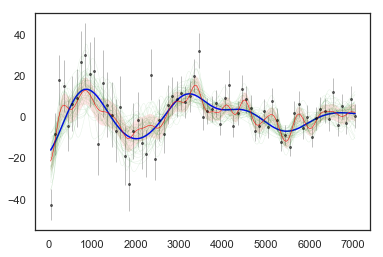

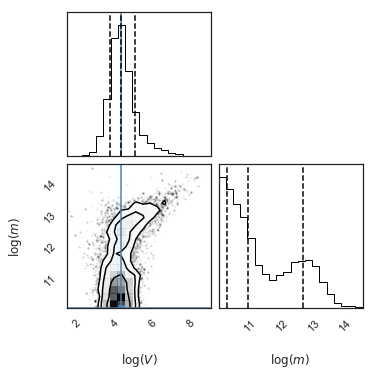

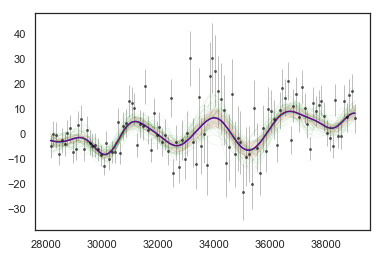

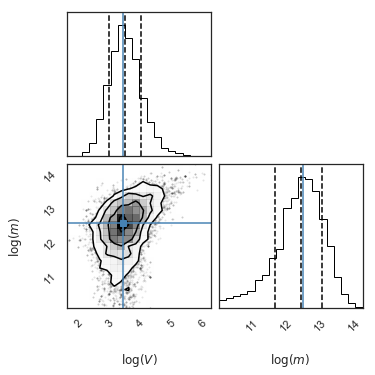

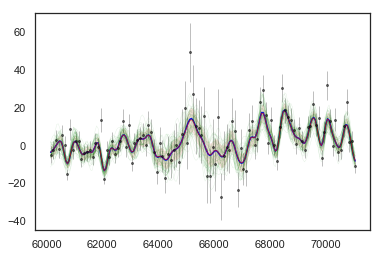

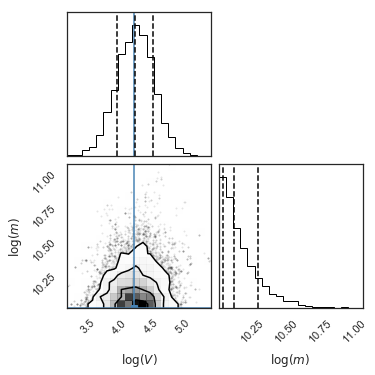

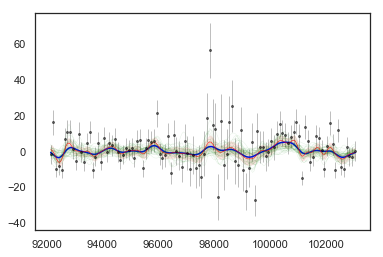

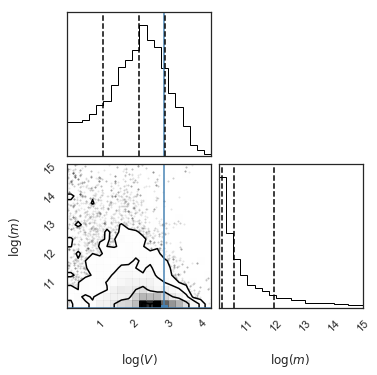

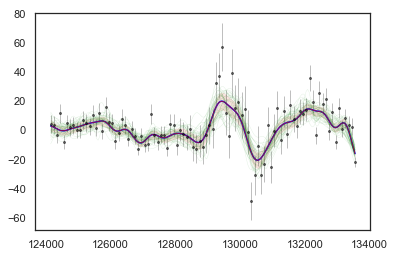

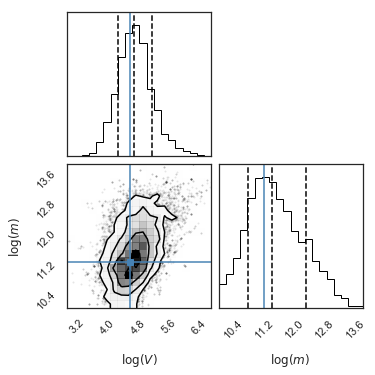

In [14]:
tsel, rsel, esel = res[-3:]
HPs = fit_gp_all(tsel, rsel, esel)

### Now fit Gaussian + GP, using previous exercise to set the initial values

In [15]:
def nll_gauss_gp(p, t, y, e, gp):
    if abs(p[-2]-5)>5:
        return 1e25
    if abs(p[-1]-12.5)>2.5:
        return 1e25
    gp.set_parameter_vector(p[4:])
    try:
        gp.compute(t, yerr = e)
    except: 
        return 1e25
    m = gauss(p[:4], t)
    r = y - m
    return -gp.log_likelihood(r)

In [17]:
def lnprob_gauss_gp(p, t, y, e, gp):
    return - nll_gauss_gp(p, t, y, e, gp)

def mcmc_gauss_gp(t, y, e, p_gauss_in, gp, nburn = 1000, nrun = 500):
    p_in = np.concatenate([p_gauss_in, gp.get_parameter_vector()])
    ndim = len(p_in)
    nwalkers = max(4 * ndim, 24)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_gauss_gp, args=(t,y,e,gp))
    # Initialize the walkers.
    p0 = p_in + 1e-4 * np.random.randn(nwalkers, ndim)
    p0, _, _ = sampler.run_mcmc(p0, nburn)
    sampler.reset()
    sampler.run_mcmc(p0, nrun)
    return sampler

In [18]:
def fit_gauss_gp(t, y, e, p_gauss_in, gp):
    plt.figure()
    plt.errorbar(t,y,fmt='k.',yerr=e,capsize=0,lw=0.5,ms=4,alpha=0.5)
    # first to MLE
    p_gp_in = gp.get_parameter_vector()
    p_in = np.concatenate([p_gauss_in,p_gp_in])
    soln = minimize(nll_gauss_gp,p_in, args = (t,y,e,gp))
    p_mle = soln.x
    gp.set_parameter_vector(p_mle[-2:])
    gp.compute(t, yerr=e)
    m_mle = gauss(p_mle[:4], t)
    r_mle = y - m_mle
    treg = np.linspace(min(t), max(t), 200)
    mreg = gauss(p_mle[:4], treg) + gp.predict(r_mle,treg,return_cov=False,return_var=False)
    plt.plot(treg,mreg,'b-')
    sampler = mcmc_gauss_gp(t, y, e, p_mle[:4], gp)
    for i in range(50):
        # Choose a random walker and step.
        w = np.random.randint(sampler.chain.shape[0])
        n = np.random.randint(sampler.chain.shape[1])
        p = sampler.chain[w, n]
        # Plot a single sample.
        gp.set_parameter_vector(p[-2:])
        gp.compute(t, yerr=e)
        m = gauss(p[:4],t)
        r = y - m
        mreg = gauss(p[:4],treg) + gp.sample_conditional(r,treg).flatten()        
        plt.plot(treg, mreg, "g-", alpha=0.1,lw = 0.5)
    samples = sampler.flatchain
    logL = sampler.flatlnprobability
    p_map = samples[np.argmax(logL),:].flatten()
    gp.set_parameter_vector(p_map[-2:])
    gp.compute(t, yerr=e)
    m_map = gauss(p_map[:4], t)
    r_map = y - m_map
    mreg = gauss(p_map[:4], treg)
    mreg_gp, vreg_gp = gp.predict(r_map,treg,return_cov=False,return_var=True)
    sreg_gp = np.sqrt(vreg_gp)
    mreg_gp += mreg
    plt.plot(treg, mreg, ls="-",color='orange')
    plt.plot(treg, mreg_gp, "r-",lw = 0.5)
    plt.fill_between(treg, mreg_gp+sreg_gp,mreg_gp-sreg_gp, color="r", alpha=0.1,lw = 0.0)
    ndim = len(p_map)
    p_med = np.zeros(ndim)
    p_err_down = np.zeros(ndim)
    p_err_up = np.zeros(ndim)
    for i in range(ndim):
        p = samples[:,i].flatten()
        l,m,u = np.percentile(p, [16, 50, 84])
        p_med[i] = m
        p_err_down[i] = m-l
        p_err_up[i] = u-m
    labels = np.array([r"$A$", r"$\mu$", r"$\sigma$",r"$C$",r'$\log(V)$',r'$\log(m)$'])
    names = np.array(['amp','loc','half-width','DC','log_var','log_metric'])
    corner.corner(sampler.flatchain, quantiles=[0.16, 0.5, 0.84],truths=p_map,labels=labels)
    return names, (p_mle, p_map),(p_med,p_err_down,p_err_up)

5


In [ ]:
def fit_gauss_gp_all(t, y, e, p_gauss_in, gp_HPs_in):
    n_orbit = len(p_gauss_in)
    orbit = []
    par_mle = []
    par_map = []
    par_med = []
    par_err_down = []
    par_err_up = []
    for io in range(n_orbit):
    
    k = gp_var * kernels.ExpSquaredKernel(gp_metric)
        gp = GP(k,mean = 0, fit_mean=False)
        p_in = np.concatenate([p_in, gp.get_parameter_vector()])
    
    w = 14 * sig_in
    t0 = t0_in
    p_in = np.array([amp_in,t0,sig_in,np.median(y)])
    if use_gp:
    while (t0 - w/2.) < t.max():
        l = abs(t-t0) <= (w/2.)
        if l.sum() > 0:
            p_in[1] = t0
            print(p_in)
            if use_gp:
                p_mle, p_map, p_med, p_err_down, p_err_up, names = fit_gauss(t[l], y[l], e[l], p_in, gp)
            else:
                p_mle, p_map, p_med, p_err_down, p_err_up, names = fit_gauss(t[l], y[l], e[l], p_in)
            p_in = p_map
            par_mle.append(p_mle)
            par_map.append(p_map)
            par_med.append(p_med)
            par_err_down.append(p_err_down)
            par_err_up.append(p_err_up)
            orbit.append(o)
            print('Orbit: {:d}'.format(o))
            print('{:20s} {:10s} {:10s} {:10s} + {:10s} - {:10s}' \
                  .format('Parameter','ML', 'MAP', 'Med', 'sig_up', 'sig_down'))
            for i in range(len(p_mle)):
                print('{:20s} {:10.1f} {:10.1f} {:10.1f} + {:10.1f} - {:10.1f}' \
                      .format(names[i], p_mle[i], p_map[i], p_med[i], p_err_up[i], p_err_down[i]))
        t0 += per_in
        o += 1
    return orbit, par_mle, par_map, par_med, par_err_down, par_err_up

### Now do it with GP

<font color=red>To use GP need to first fit without GP, model residuals with GP to initialise HPs, then do joint fit.</font>

In [ ]:
res = fit_gauss_all(tbin,ybin,sbin,use_gp=True)

### So which parameters vary from pulse to pulse and how much?

#### <font color=red>TBD: fit ephemeris properly:</font>
- <font color=red>accounting for individual uncertainties on individual times</font>
- <font color=red>using one period for all pulses but different offsets for odd and even</font>
- <font color=red>computing uncertainties on ephemeris parameters</font>

In [ ]:
orbit, amp_fit, mu_fit, sig_fit, dc_fit, amp_err, mu_err, sig_err, dc_err = res
fig,axes = plt.subplots(5,1,figsize=(10,10),sharex =True)
axes[0].errorbar(orbit,amp_fit,yerr=amp_err,fmt='.')
axes[1].errorbar(orbit,mu_fit,yerr=mu_err,fmt='.')
orb = np.array(orbit)
mus = np.array(mu_fit)
mue = np.array(mu_err)
l_odd = (orb%2)==1
print(l_odd)
l_even = ~l_odd
print(l_even)
p_odd = np.polyfit(orb[l_odd],mus[l_odd],1)
v_odd = np.polyval(p_odd,orb[l_odd])
print(p_odd)
p_even = np.polyfit(orb[l_even],mus[l_even],1)
print(p_even)
v_even = np.polyval(p_even,orb[l_even])
p_even = np.polyfit(np.array(orbit)[1::2],np.array(mu_fit)[1::2],1)
axes[2].errorbar(orb[l_odd],mus[l_odd]-v_odd,yerr=mue[l_odd],fmt='.',color='r')
axes[2].errorbar(orb[l_even],mus[l_even]-v_even,yerr=mue[l_even],fmt='.',color='b')
axes[3].errorbar(orbit,sig_fit,yerr=sig_err,fmt='.')
axes[4].errorbar(orbit,dc_fit,yerr=dc_err,fmt='.')
axes[0].set_ylabel('amplitude')
axes[1].set_ylabel('position')
axes[2].set_ylabel('O-C')
axes[3].set_ylabel('half-width')
axes[4].set_ylabel('dc level')
axes[4].set_xlabel('orbit number')


### In case I accidentally delete cells containing important functions again...

In [ ]:
def rescue_code(function):
    import inspect
    get_ipython().set_next_input("".join(inspect.getsourcelines(function)[0]))